# Rule-Based Baseline

**Approach**: Exact and fuzzy string matching against lookup tables

This is the simplest baseline approach:
1. Load lookup tables (department-v2.csv, seniority-v2.csv)
2. For each job title, find best match using:
   - Exact match (highest confidence)
   - Fuzzy match (edit distance, token overlap)
   - Default fallback if no good match
3. Evaluate on annotated dataset

**Training Data**: Lookup tables (~19k examples)  
**Validation Data**: Annotated LinkedIn CVs (loaded only for evaluation)

In [27]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import data loaders and models
import sys
sys.path.append('../')
from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset
from src.models.rule_based import RuleBasedClassifier, HybridRuleClassifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Training Data (Lookup Tables)

In [28]:
# Load lookup tables
dept_df, sen_df = load_label_lists(DATA_DIR)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")
print(f"\nUnique departments: {dept_df['label'].nunique()}")
print(f"Unique seniority levels: {sen_df['label'].nunique()}")

Department lookup: 10,145 examples
Seniority lookup:  9,428 examples

Unique departments: 11
Unique seniority levels: 5


## 2. Build Rule-Based Classifiers

In [29]:
from src.models.rule_based import RuleConfig
# Configure with fuzzy threshold
config = RuleConfig(fuzzy_threshold=0.8)
dept_clf = HybridRuleClassifier(dept_df, config=config)
sen_clf = HybridRuleClassifier(sen_df, config=config)
print("✅ Department classifier created")
print("✅ Seniority classifier created")
print(f"\nConfiguration:")
print(f"  Fuzzy match threshold: {config.fuzzy_threshold} (80% similarity required)")
print(f"  Exact match: {config.use_exact_match}")
print(f"  Substring match: {config.use_substring_match}")
print(f"  Keyword match: {config.use_keyword_match}")

✅ Department classifier created
✅ Seniority classifier created

Configuration:
  Fuzzy match threshold: 0.8 (80% similarity required)
  Exact match: True
  Substring match: True
  Keyword match: True


## 3. Inference Demo on Unannotated CVs

In [30]:
# Load unannotated CVs for demonstration
inference_df = load_inference_dataset(DATA_DIR)

print(f"Loaded {len(inference_df):,} unannotated CV positions for inference demo")
print(f"\nFirst few job titles:")
for i, row in inference_df.head(10).iterrows():
    print(f"  {i+1}. {row['title']}")

Loaded 314 unannotated CV positions for inference demo

First few job titles:
  1. Bookkeeper
  2. Strategy & Investments
  3. Corporate Auditor
  4. Marketing Manager
  5. Professor
  6. Program Purchasing Leader / Program / Acquisition Buyer
  7. Business Analyst
  8. Managementberater IT- und Governance
  9. Founder & CEO
  10. Geschäftsführer


In [31]:
# Make predictions on sample
sample_titles = inference_df['title'].head(20).tolist()

# Predict with details (includes match method and confidence)
dept_preds = dept_clf.predict_with_details(sample_titles)
sen_preds = sen_clf.predict_with_details(sample_titles)

# Display results
print("\n" + "="*100)
print("INFERENCE DEMO: Rule-Based Predictions")
print("="*100)
print(f"{'Title':<40} | {'Department':<20} | {'Seniority':<15} | {'Methods':<20}")
print("-"*100)

for title, (dept, dept_conf, dept_method), (sen, sen_conf, sen_method) in zip(sample_titles, dept_preds, sen_preds):
    title_short = title[:37] + "..." if len(title) > 40 else title
    methods = f"{dept_method[:4]}/{sen_method[:4]}"
    print(f"{title_short:<40} | {dept:<20} | {sen:<15} | {methods:<20}")


INFERENCE DEMO: Rule-Based Predictions
Title                                    | Department           | Seniority       | Methods             
----------------------------------------------------------------------------------------------------
Bookkeeper                               | Other                | Other           | defa/defa           
Strategy & Investments                   | Other                | Other           | defa/defa           
Corporate Auditor                        | Other                | Other           | defa/defa           
Marketing Manager                        | Marketing            | Senior          | exac/exac           
Professor                                | Other                | Other           | defa/defa           
Program Purchasing Leader / Program /... | Other                | Other           | defa/defa           
Business Analyst                         | Business Development | Junior          | exac/exac           
Managementberater I

## 4. Match Method Statistics

Let's analyze which matching strategies are being used most often.

In [32]:
# Analyze matching methods on inference data
all_titles = inference_df['title'].tolist()
dept_stats = dept_clf.get_stats(all_titles)
sen_stats = sen_clf.get_stats(all_titles)

print("Department Classification Methods:")
for method, count in dept_stats.items():
    pct = 100 * count / len(all_titles)
    print(f"  {method:<15}: {count:>5} ({pct:>5.1f}%)")

print("\nSeniority Classification Methods:")
for method, count in sen_stats.items():
    pct = 100 * count / len(all_titles)
    print(f"  {method:<15}: {count:>5} ({pct:>5.1f}%)")

Department Classification Methods:
  exact          :    24 (  7.6%)
  substring      :    26 (  8.3%)
  keyword        :     0 (  0.0%)
  default        :   264 ( 84.1%)

Seniority Classification Methods:
  exact          :    91 ( 29.0%)
  substring      :    77 ( 24.5%)
  keyword        :     0 (  0.0%)
  default        :   146 ( 46.5%)


## 5. Evaluation on Annotated Dataset

⚠️ **FIRST TIME LOADING ANNOTATED DATA**

Now we evaluate on the held-out annotated dataset to get true performance metrics.

In [33]:
# Load annotated dataset for evaluation
eval_df = load_evaluation_dataset(DATA_DIR)

print(f"📊 Loaded {len(eval_df)} annotated CV positions for evaluation")
print(f"\nColumns: {list(eval_df.columns)}")
print(f"\nChecking for missing labels:")
print(f"  Missing department labels: {eval_df['department'].isna().sum()}")
print(f"  Missing seniority labels: {eval_df['seniority'].isna().sum()}")

📊 Loaded 478 annotated CV positions for evaluation

Columns: ['cv_id', 'title', 'company', 'text', 'department', 'seniority']

Checking for missing labels:
  Missing department labels: 0
  Missing seniority labels: 0


### 5.1 Department Evaluation

In [34]:
# Predict on evaluation set
eval_titles = eval_df['title'].tolist()
dept_predictions = dept_clf.predict(eval_titles)

# Ground truth
dept_true = eval_df['department'].tolist()

# Calculate metrics
dept_accuracy = accuracy_score(dept_true, dept_predictions)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_true, dept_predictions, average='macro', zero_division=0
)
dept_weighted_f1 = precision_recall_fscore_support(
    dept_true, dept_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("DEPARTMENT CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_weighted_f1:.4f}")
print("="*60)


DEPARTMENT CLASSIFICATION RESULTS
Accuracy:          0.6569
Precision (macro): 0.6128
Recall (macro):    0.3224
F1-score (macro):  0.3863
F1-score (wtd):    0.5860


In [35]:
# Per-class F1 scores
dept_report = classification_report(dept_true, dept_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Department):")
dept_f1_scores = {label: metrics['f1-score'] for label, metrics in dept_report.items() 
                  if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(dept_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Department):
  Other                         : 0.7623
  Sales                         : 0.7333
  Consulting                    : 0.6667
  Project Management            : 0.5714
  Purchasing                    : 0.5000
  Marketing                     : 0.4000
  Business Development          : 0.3333
  Administrative                : 0.1818
  Information Technology        : 0.1000
  Customer Support              : 0.0000
  Human Resources               : 0.0000


### 5.2 Seniority Evaluation

In [36]:
# Predict on evaluation set
sen_predictions = sen_clf.predict(eval_titles)

# Ground truth
sen_true = eval_df['seniority'].tolist()

# Calculate metrics
sen_accuracy = accuracy_score(sen_true, sen_predictions)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_true, sen_predictions, average='macro', zero_division=0
)
sen_weighted_f1 = precision_recall_fscore_support(
    sen_true, sen_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("SENIORITY CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_weighted_f1:.4f}")
print("="*60)


SENIORITY CLASSIFICATION RESULTS
Accuracy:          0.2699
Precision (macro): 0.3875
Recall (macro):    0.2703
F1-score (macro):  0.2870
F1-score (wtd):    0.3363


In [37]:
# Per-class F1 scores
sen_report = classification_report(sen_true, sen_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Seniority):")
sen_f1_scores = {label: metrics['f1-score'] for label, metrics in sen_report.items() 
                 if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(sen_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Seniority):
  Management                    : 0.6439
  Director                      : 0.4746
  Lead                          : 0.4672
  Senior                        : 0.2326
  Junior                        : 0.1905
  Other                         : 0.0000
  Professional                  : 0.0000


## 6. Confusion Matrices

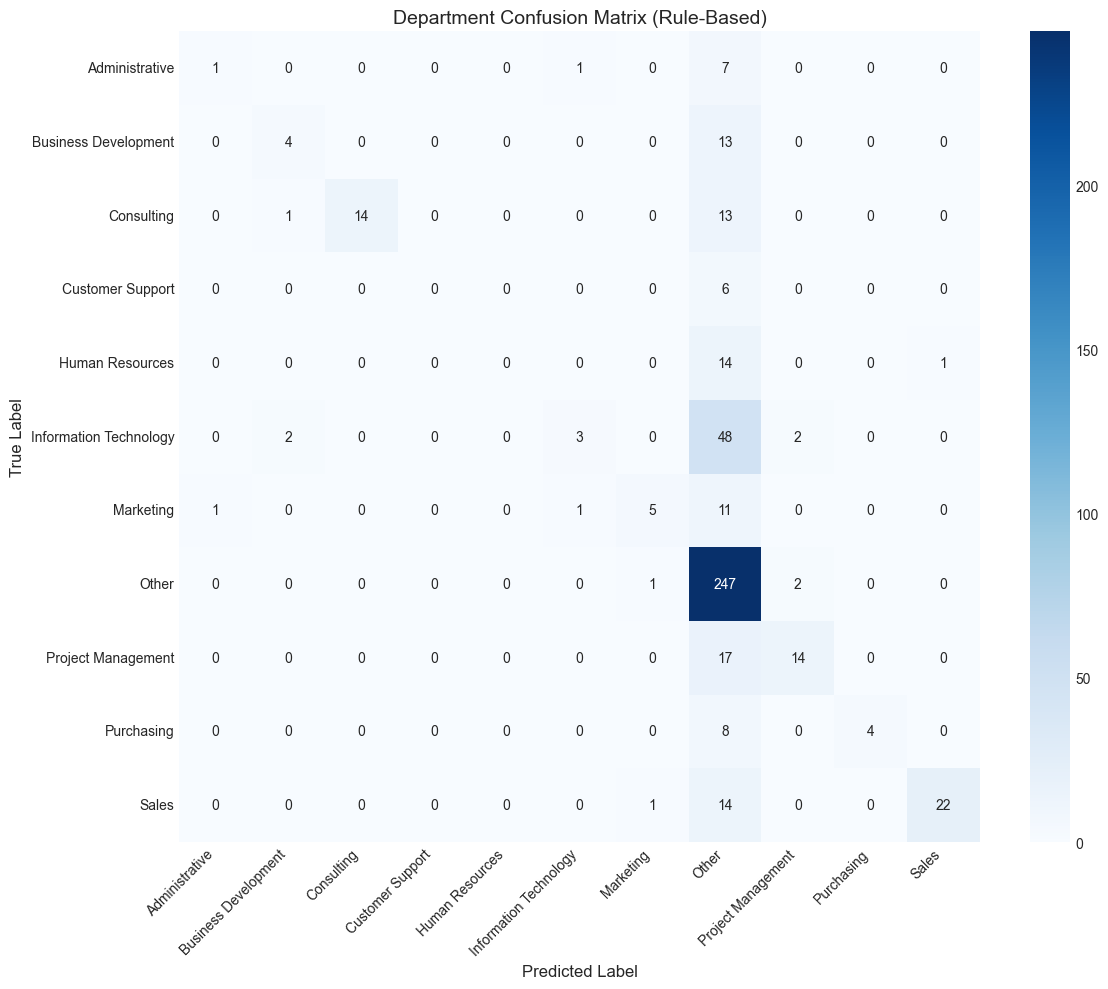

In [38]:
# Department confusion matrix
dept_cm = confusion_matrix(dept_true, dept_predictions)
dept_labels = sorted(set(dept_true + dept_predictions))

plt.figure(figsize=(12, 10))
sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels)
plt.title('Department Confusion Matrix (Rule-Based)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

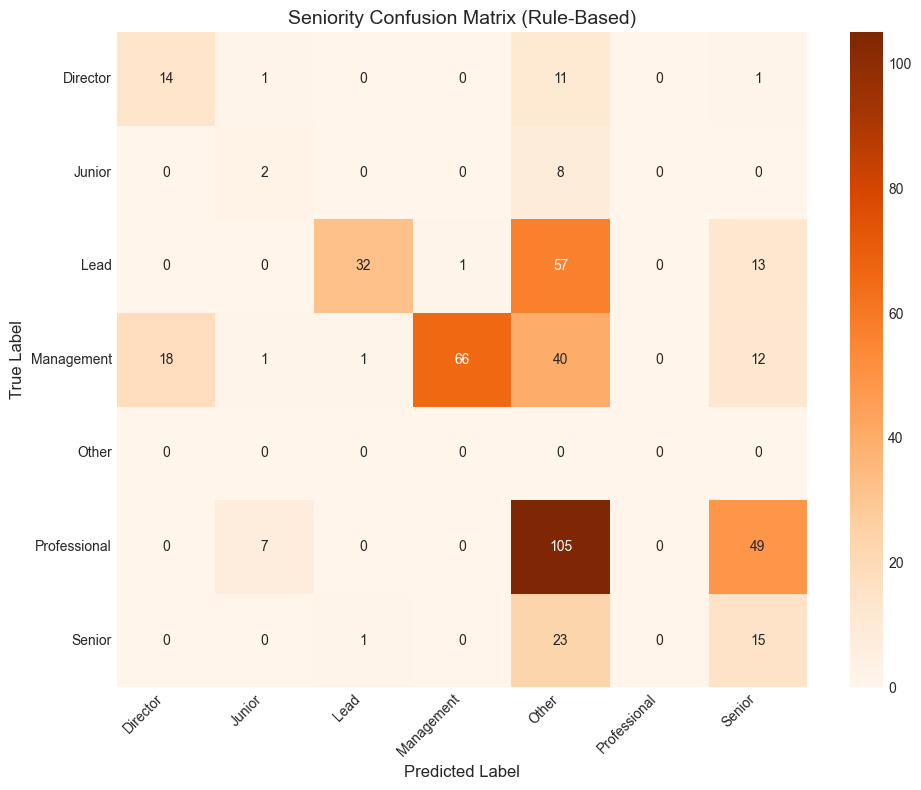

In [39]:
# Seniority confusion matrix
sen_cm = confusion_matrix(sen_true, sen_predictions)
sen_labels = sorted(set(sen_true + sen_predictions))

plt.figure(figsize=(10, 8))
sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels)
plt.title('Seniority Confusion Matrix (Rule-Based)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Error Analysis

In [40]:
# Find misclassified examples
eval_df['dept_pred'] = dept_predictions
eval_df['sen_pred'] = sen_predictions
eval_df['dept_correct'] = eval_df['department'] == eval_df['dept_pred']
eval_df['sen_correct'] = eval_df['seniority'] == eval_df['sen_pred']

# Department errors
dept_errors = eval_df[~eval_df['dept_correct']]
print(f"\nDepartment errors: {len(dept_errors)} / {len(eval_df)} ({100*len(dept_errors)/len(eval_df):.1f}%)")
print("\nExample misclassifications (Department):")
for i, row in dept_errors.head(10).iterrows():
    print(f"\n  Title: {row['title']}")
    print(f"    True: {row['department']}")
    print(f"    Pred: {row['dept_pred']}")

# Seniority errors
sen_errors = eval_df[~eval_df['sen_correct']]
print(f"\n{'='*80}")
print(f"Seniority errors: {len(sen_errors)} / {len(eval_df)} ({100*len(sen_errors)/len(eval_df):.1f}%)")
print("\nExample misclassifications (Seniority):")
for i, row in sen_errors.head(10).iterrows():
    print(f"\n  Title: {row['title']}")
    print(f"    True: {row['seniority']}")
    print(f"    Pred: {row['sen_pred']}")


Department errors: 164 / 478 (34.3%)

Example misclassifications (Department):

  Title: Solutions Architect
    True: Information Technology
    Pred: Other

  Title: Medizintechnik Beratung
    True: Consulting
    Pred: Other

  Title: Director expansión de negocio.
    True: Business Development
    Pred: Other

  Title: APL-ansvarig, samordning
    True: Administrative
    Pred: Other

  Title: Kaufmännischer Leiter
    True: Sales
    Pred: Other

  Title: Human Resources Generalist
    True: Human Resources
    Pred: Other

  Title: energy and sustainability consultant bei
    True: Consulting
    Pred: Other

  Title: Geschäftsführer, CMO
    True: Marketing
    Pred: Other

  Title: Principal RF Design Engineer
    True: Information Technology
    Pred: Other

  Title: IT Systems and Network Engineer
    True: Information Technology
    Pred: Other

Seniority errors: 349 / 478 (73.0%)

Example misclassifications (Seniority):

  Title: Prokurist
    True: Management
    Pred: 

## 8. Save Results for Comparison

Save evaluation results to JSON for final comparison notebook.

In [41]:
# Prepare results dictionary
results = {
    "approach": "Rule-Based (Exact + Fuzzy Matching)",
    "department": {
        "accuracy": float(dept_accuracy),
        "precision": float(dept_precision),
        "recall": float(dept_recall),
        "f1_macro": float(dept_f1),
        "f1_weighted": float(dept_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()}
    },
    "seniority": {
        "accuracy": float(sen_accuracy),
        "precision": float(sen_precision),
        "recall": float(sen_recall),
        "f1_macro": float(sen_f1),
        "f1_weighted": float(sen_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()}
    },
    "metadata": {
        "training_samples": len(dept_df) + len(sen_df),
        "dept_training_samples": len(dept_df),
        "sen_training_samples": len(sen_df),
        "fuzzy_threshold": 0.8,
        "match_methods": {
            "department": dept_stats,
            "seniority": sen_stats
        }
    },
    "timestamp": datetime.now().isoformat()
}

# Save to JSON
output_path = RESULTS_DIR / 'rule_based_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {output_path}")
print(f"\nSummary:")
print(f"  Department - Accuracy: {dept_accuracy:.4f}, F1 (macro): {dept_f1:.4f}")
print(f"  Seniority  - Accuracy: {sen_accuracy:.4f}, F1 (macro): {sen_f1:.4f}")


✅ Results saved to: results\rule_based_results.json

Summary:
  Department - Accuracy: 0.6569, F1 (macro): 0.3863
  Seniority  - Accuracy: 0.2699, F1 (macro): 0.2870


---

## Summary

### Strengths
- ✅ Fast inference (no model loading)
- ✅ Interpretable (can see which rule matched)
- ✅ Works well for exact/near-exact matches
- ✅ No training required

### Limitations
- ❌ Poor generalization to unseen patterns
- ❌ Relies heavily on exact string similarity
- ❌ Cannot capture semantic meaning
- ❌ Struggles with complex/long job titles

### Next Steps
- **Notebook 03**: Embedding-based approach (captures semantics)
- **Notebook 04**: Transformer fine-tuning (learns patterns)
- **Notebook 99**: Compare all approaches